In [ ]:
#Importing Libraries

In [2]:
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPool2D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import os
from numpy.linalg import norm
from sklearn.decomposition import PCA
#imports for training time visualization
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
#Extract Filenames from Folder

In [4]:
filenames = []
for file in os.listdir('images'):
    filenames.append(os.path.join('images',file))
    

In [5]:
print(len(filenames))
print(filenames[0])

44441
images\10000.jpg


In [6]:
#Importing ResNet50 Model and Cofiguration

In [7]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
model.trainable = False

model = tf.keras.models.Sequential([model,
                                   GlobalMaxPool2D()
                                   ])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
#Extracting Fetaures from Image So that we use that features to map the nearest neighbours 

In [9]:
#TESTING THE CODE OF EXTRACTING FEATURES FOR ONE GIVEN IMAGE

In [10]:
img = image.load_img('./images/1163.jpg', target_size=(224,224))
img_array = image.img_to_array(img)
img_expand_dim = np.expand_dims(img_array, axis=0)
img_preprocess = preprocess_input(img_expand_dim)
result = model.predict(img_preprocess).flatten()
norm_result = result/norm(result)
norm_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([0.00491866, 0.05812978, 0.00543877, ..., 0.00351522, 0.05245367,
       0.03639519], dtype=float32)

In [11]:
# FUNCTION TO EXTRACT FEATURES - SO THAT WE CAN CALL THIS FOR THE WHOLE DATASET

In [12]:
def extract_features_from_images(image_path, model):
    img = image.load_img(image_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_expand_dim = np.expand_dims(img_array, axis=0)
    img_preprocess = preprocess_input(img_expand_dim)
    result = model.predict(img_preprocess).flatten()
    norm_result = result/norm(result)
    return norm_result

In [13]:
extract_features_from_images(filenames[0], model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


array([0.        , 0.01761619, 0.00171607, ..., 0.01247238, 0.027264  ,
       0.06899219], dtype=float32)

In [ ]:
image_features = []
for file in filenames:
    image_features.append(extract_features_from_images(file, model))
image_features

In [ ]:
Image_features = pkl.dump(image_features, open('Images_features.pkl','wb'))

In [ ]:
filenames = pkl.dump(filenames, open('filenames.pkl','wb'))

In [ ]:
#Loading Pickle Files

In [14]:
Image_features = pkl.load(open('Images_features.pkl','rb'))

In [15]:
filenames = pkl.load(open('filenames.pkl','rb'))

In [16]:
np.array(Image_features).shape

(44441, 2048)

In [17]:
#Finidng Simialar Images

In [18]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')

In [19]:
neighbors.fit(Image_features)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [20]:
input_image = extract_features_from_images('16871.jpg',model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


In [21]:
distance,indices = neighbors.kneighbors([input_image])

In [22]:
indices[0]

array([ 5828,  5799, 34267, 16489,  6257,  5814], dtype=int64)

In [23]:
from IPython.display import Image

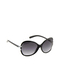

In [24]:
# Testing ou algorithm ouput with a static input and static output
Image('16871.jpg')

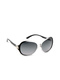

In [25]:
Image(filenames[indices[0][1]])

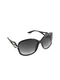

In [26]:
Image(filenames[indices[0][2]])

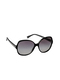

In [27]:
Image(filenames[indices[0][3]])

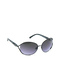

In [28]:
Image(filenames[indices[0][4]])

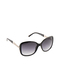

In [29]:
Image(filenames[indices[0][5]])

In [ ]:
import random

def retrieval_accuracy(filenames, model, n_samples=10, n_neighbors=6):
    correct = 0
    for _ in range(n_samples):
        # Randomly select an image
        query_index = random.randint(0, len(filenames) - 1)
        query_image = filenames[query_index]

        
        query_features = extract_features_from_images(query_image, model)

        
        distances, indices = neighbors.kneighbors([query_features])

        
        if query_index in indices[0]:
            correct += 1

    accuracy = correct / n_samples
    return accuracy


accuracy = retrieval_accuracy(filenames, model)
print(f"Retrieval Accuracy: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Retrieval Accuracy: 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


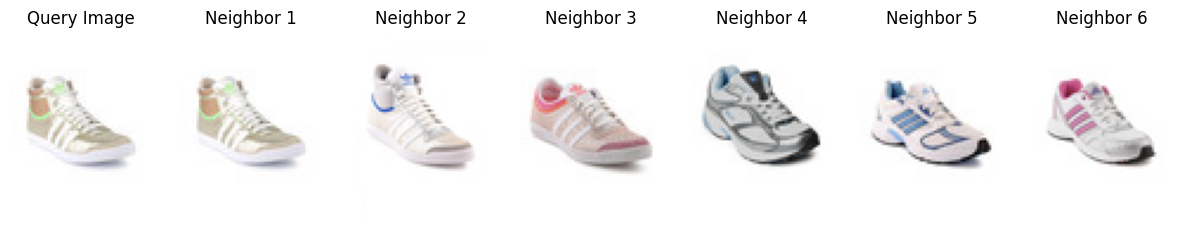

In [ ]:
def visualize_retrieval(filenames, model, neighbors, n_neighbors=6):
    query_index = random.randint(0, len(filenames) - 1)
    query_image = filenames[query_index]
    query_features = extract_features_from_images(query_image, model)
    distances, indices = neighbors.kneighbors([query_features])

    plt.figure(figsize=(15, 5))

    # query image
    plt.subplot(1, n_neighbors + 1, 1)
    plt.imshow(image.load_img(query_image))
    plt.title("Query Image")
    plt.axis('off')

    # Show nearest neighbors
    for i, idx in enumerate(indices[0]):
        plt.subplot(1, n_neighbors + 1, i + 2)
        plt.imshow(image.load_img(filenames[idx]))
        plt.title(f"Neighbor {i + 1}")
        plt.axis('off')

    plt.show()

# VisualizIing a random retrieval from the dataset
visualize_retrieval(filenames, model, neighbors)


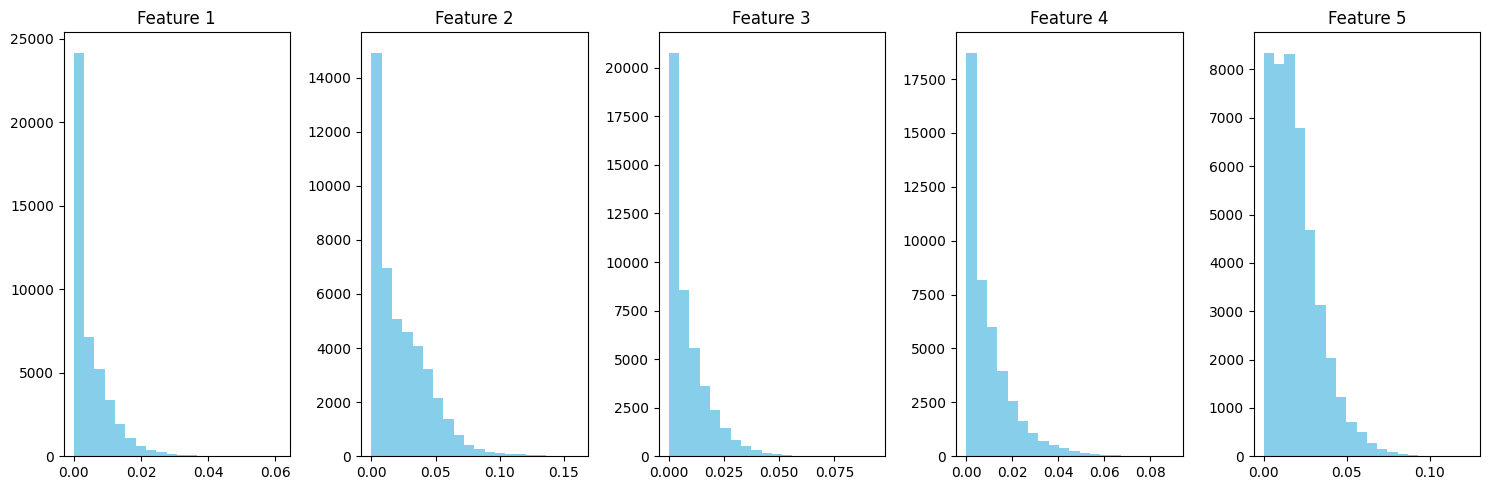

In [ ]:
import matplotlib.pyplot as plt

# Load the precomputed features
Image_features = pkl.load(open('Images_features.pkl','rb'))

# Convert to a NumPy array for easier manipulation
image_features_array = np.array(Image_features)

# Plotting histograms of the first few features
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.hist(image_features_array[:, i], bins=20, color='skyblue')
    plt.title(f'Feature {i+1}')
plt.tight_layout()
plt.show()


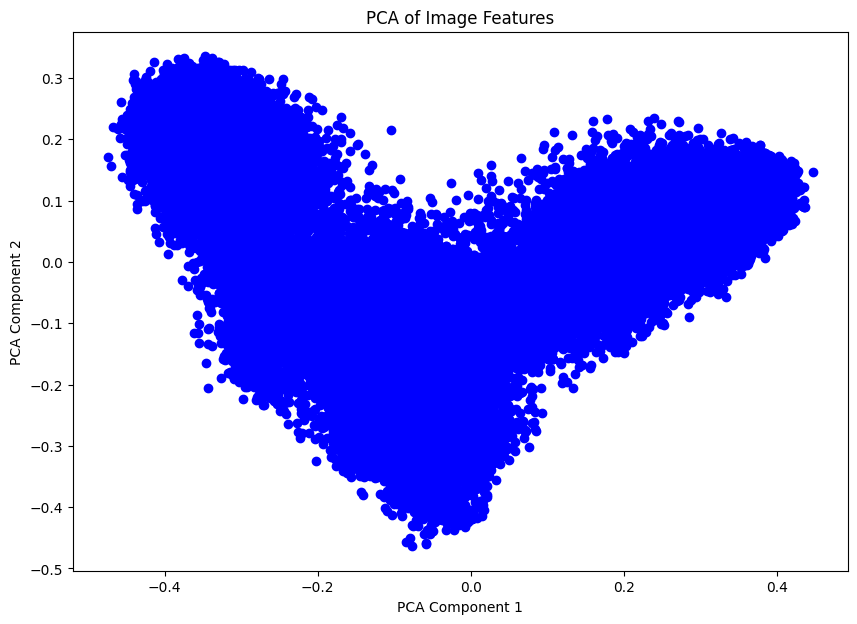

In [ ]:
    
    image_features = pkl.load(open('Images_features.pkl', 'rb'))
    
    # Reducing the dimensions to 2D for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(image_features)
    
    # PLotting our 2D representation of the feature vectors
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', marker='o')
    
    plt.title('PCA of Image Features')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    
    # # If you want to annotate the points with filenames we can use this code in extra but as we have large set then this would make it clumpsy
    # for i in range(len(filenames)):
    #     plt.annotate(os.path.basename(filenames[i]), (pca_result[i, 0], pca_result[i, 1]))
    
    plt.show()

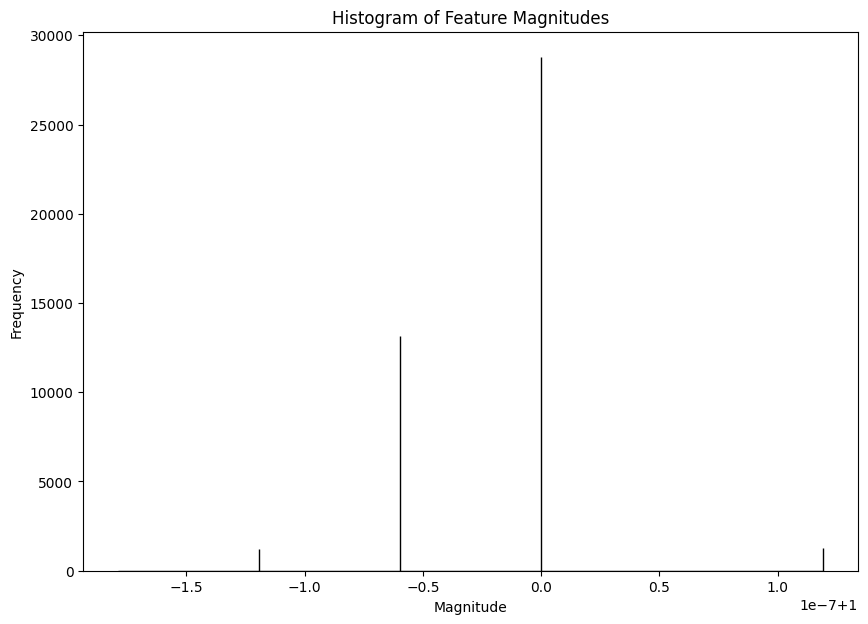

In [ ]:
import numpy as np

# Compute the magnitude of each feature vector
magnitude = np.linalg.norm(image_features, axis=1)

# Plot histogram
plt.figure(figsize=(10, 7))
plt.hist(magnitude, bins=30, color='blue', edgecolor='black')

plt.title('Histogram of Feature Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()


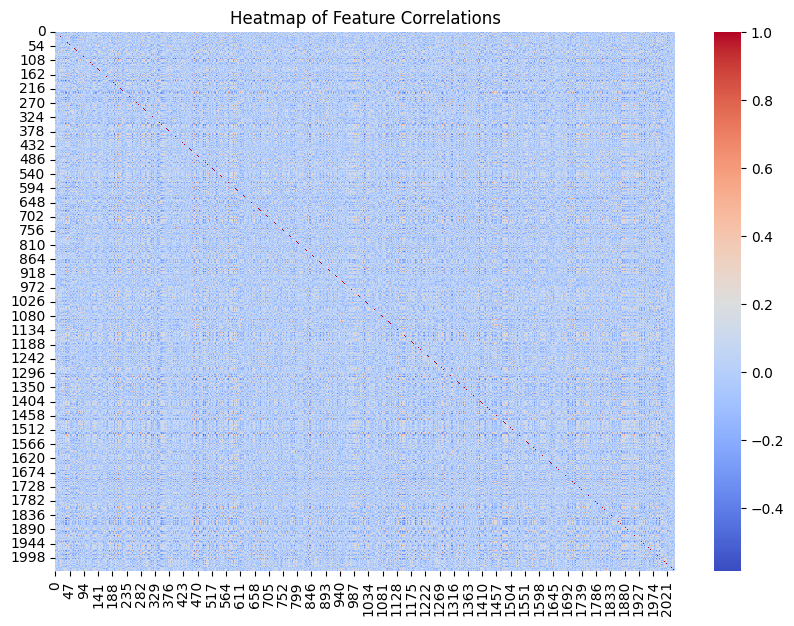

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


image_features = np.array(image_features)

# correlation matrix
correlation_matrix = np.corrcoef(image_features, rowvar=False)


plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Heatmap of Feature Correlations')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


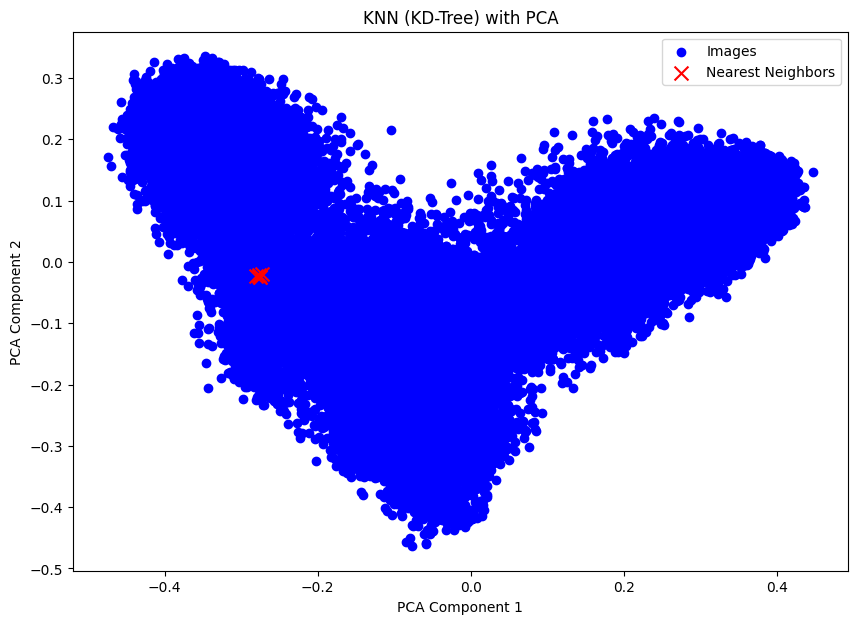

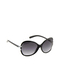

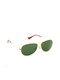

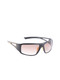

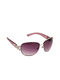

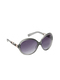

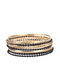

Execution Time for KNN with KD-Tree: 1.6310231685638428 seconds


In [ ]:
#KNN algorithm with kd tree
from sklearn.neighbors import NearestNeighbors
import time
import matplotlib.pyplot as plt
from PIL import Image

# KNN with KD-Tree
start_time = time.time()

# Apply PCA to the entire Image_features (this reduces the dimensionality of your dataset)
Image_features_pca = pca.transform(Image_features)

# Train KNN on the PCA-transformed features
knn_kdtree = NearestNeighbors(n_neighbors=6, algorithm='kd_tree', metric='euclidean')
knn_kdtree.fit(Image_features_pca)  # Now fitting on the PCA-transformed features

# Extract features from the input image and transform them using the same PCA
input_image_feature = extract_features_from_images('16871.jpg', model)
input_image_pca = pca.transform([input_image_feature])  # Transforming input image feature using PCA

# Find the nearest neighbors for the PCA-transformed input image
distance, indices = knn_kdtree.kneighbors(input_image_pca)

# Plot the PCA results
plt.figure(figsize=(10, 7))

# Scatter plot for all the PCA-transformed image features
plt.scatter(Image_features_pca[:, 0], Image_features_pca[:, 1], c='blue', marker='o', label='Images')

# Highlight the nearest neighbors in red
plt.scatter(Image_features_pca[indices[0], 0], Image_features_pca[indices[0], 1], c='red', marker='x', s=100, label='Nearest Neighbors')

# Label the plot
plt.title('KNN (KD-Tree) with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# Show the plot
plt.show()

# Display the recommended images
for i in indices[0]:
    display(Image.open(filenames[i]))  # Make sure 'filenames' list has the correct file paths

# Print the execution time for the KNN operation
print(f"Execution Time for KNN with KD-Tree: {time.time() - start_time} seconds")


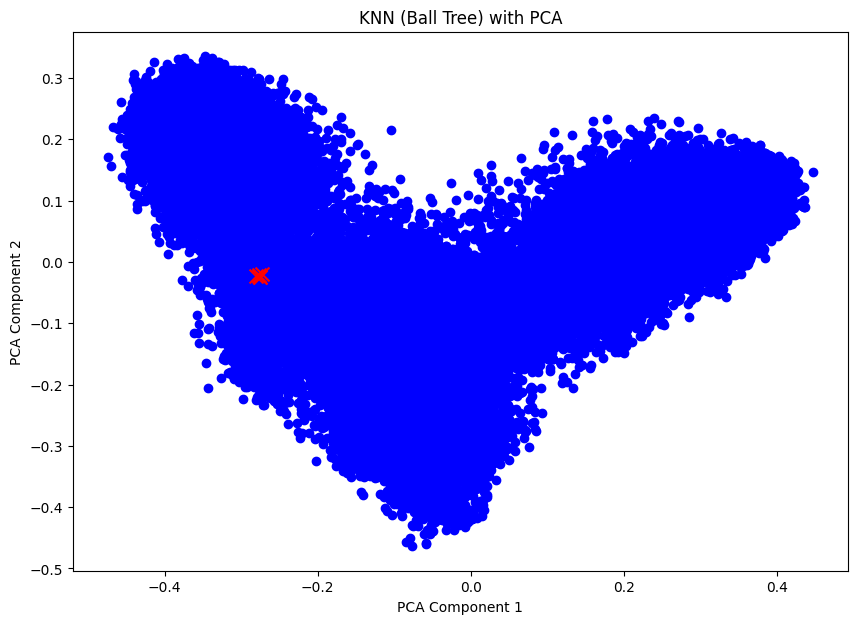

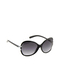

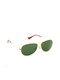

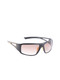

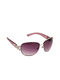

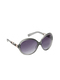

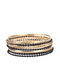

Execution Time for KNN with Ball Tree: 1.3360838890075684 seconds


In [ ]:
# KNN with Ball Tree
start_time = time.time()
knn_balltree = NearestNeighbors(n_neighbors=6, algorithm='ball_tree', metric='euclidean')
knn_balltree.fit(pca_result)

# Find the nearest neighbors for the input image
distance, indices = knn_balltree.kneighbors(input_image_pca)

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', marker='o')
plt.scatter(pca_result[indices[0], 0], pca_result[indices[0], 1], c='red', marker='x', s=100)

plt.title('KNN (Ball Tree) with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Display recommended images
for i in indices[0]:
    display(Image.open(filenames[i])) 

print(f"Execution Time for KNN with Ball Tree: {time.time() - start_time} seconds")


Execution Time for KMeans: 5.057456970214844 seconds


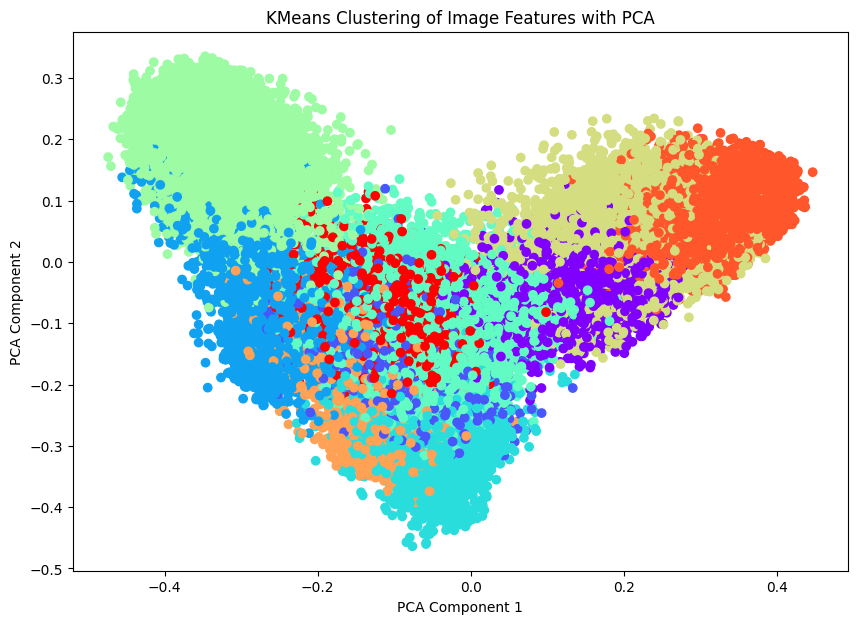

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Images recommended from Cluster 2:


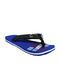

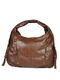

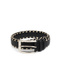

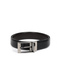

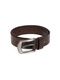

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import Image

# Assuming 'image_features' is already loaded from 'Images_features.pkl'
# and 'filenames' is loaded from 'filenames.pkl'

# Perform KMeans clustering on image features
n_clusters = 10  # You can adjust this number based on your dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Start timing the clustering process
start_time = time.time()

# Fitting KMeans to the image features
kmeans.fit(Image_features)

# Predict the cluster for each image feature
cluster_assignments = kmeans.labels_

print(f"Execution Time for KMeans: {time.time() - start_time} seconds")

# Perform PCA for 2D visualization (if not already done)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Image_features)

# Visualize the clusters with PCA
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_assignments, cmap='rainbow')
plt.title('KMeans Clustering of Image Features with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Now we get recommendations for an input image based on its cluster
def recommend_similar_images(input_image_path, model, kmeans, filenames, n_recommendations=5):
    # Extract features from the input image
    input_image_feature = extract_features_from_images(input_image_path, model)
    
    # Predict the cluster of the input image
    input_image_cluster = kmeans.predict([input_image_feature])[0]
    
    # Get indices of images in the same cluster
    similar_images_indices = np.where(cluster_assignments == input_image_cluster)[0]
    
    # Recommend 'n_recommendations' images from the same cluster
    print(f"Images recommended from Cluster {input_image_cluster}:")
    for i in similar_images_indices[:n_recommendations]:
        display(Image(filenames[i]))

# Example: Recommending images similar to '16871.jpg'
recommend_similar_images('16871.jpg', model, kmeans, filenames, n_recommendations=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Training on 10 images took 2.73 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

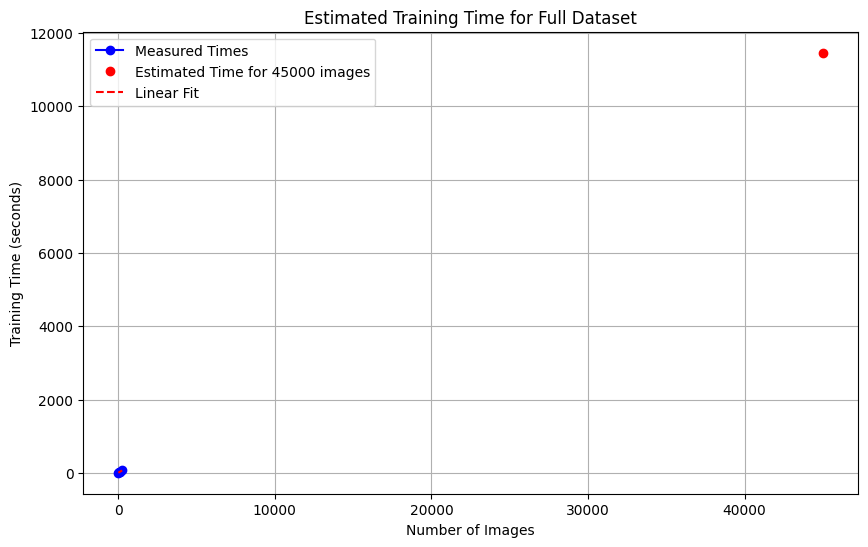

Estimated training time for 45000 images: 11463.42 seconds


In [30]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Simulate training on subsets of the dataset and record the time taken
def estimate_training_time(filenames, model, subset_sizes):
    training_times = []

    for subset_size in subset_sizes:
        subset_filenames = filenames[:subset_size]
        start_time = time.time()

        # Simulate the feature extraction process
        for file in subset_filenames:
            extract_features_from_images(file, model)

        end_time = time.time()
        elapsed_time = end_time - start_time
        training_times.append(elapsed_time)
        print(f"Training on {subset_size} images took {elapsed_time:.2f} seconds")

    return training_times

# Define the subset sizes (e.g., 100, 500, 1000, 5000, etc.)
subset_sizes = [10, 50, 100, 250]

# Estimate training times
training_times = estimate_training_time(filenames, model, subset_sizes)

# Fit a linear regression model to estimate training time for the full dataset
subset_sizes_np = np.array(subset_sizes).reshape(-1, 1)  # Reshape for linear regression
training_times_np = np.array(training_times)

linear_model = LinearRegression()
linear_model.fit(subset_sizes_np, training_times_np)

# Estimate training time for the full dataset (45000 images)
full_dataset_size = 45000
predicted_time = linear_model.predict(np.array([[full_dataset_size]]))

# Visualize the training time estimation
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, training_times, 'bo-', label='Measured Times')
plt.plot(full_dataset_size, predicted_time, 'ro', label=f'Estimated Time for {full_dataset_size} images')
plt.plot(subset_sizes, linear_model.predict(subset_sizes_np), 'r--', label='Linear Fit')
plt.xlabel('Number of Images')
plt.ylabel('Training Time (seconds)')
plt.title('Estimated Training Time for Full Dataset')
plt.legend()
plt.grid(True)
plt.show()

print(f"Estimated training time for {full_dataset_size} images: {predicted_time[0]:.2f} seconds")


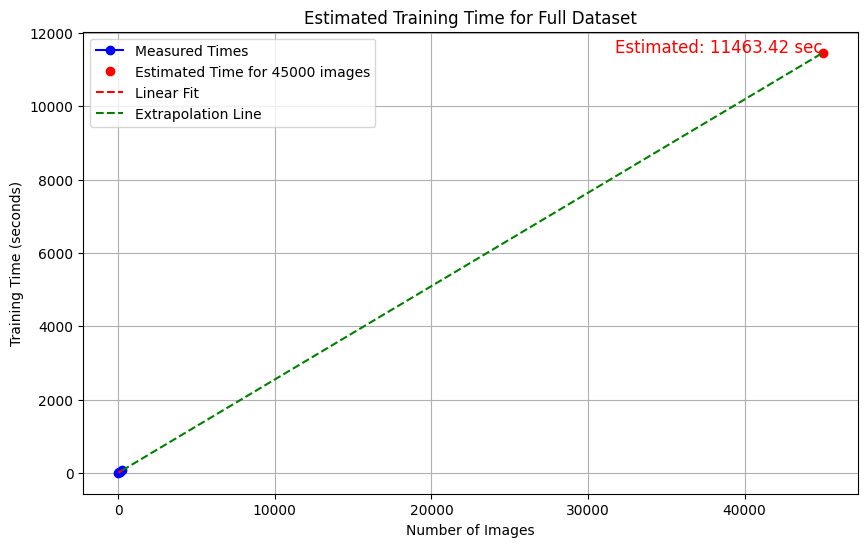

In [32]:

# Visualize the training time estimation
plt.figure(figsize=(10, 6))

# Plot the actual measured training times
plt.plot(subset_sizes, training_times, 'bo-', label='Measured Times')

# Plot the estimated time for the full dataset
plt.plot(full_dataset_size, predicted_time, 'ro', label=f'Estimated Time for {full_dataset_size} images')

# Plot the linear fit line
plt.plot(subset_sizes, linear_model.predict(subset_sizes_np), 'r--', label='Linear Fit')

# Draw a line connecting the last measured time to the estimated time
plt.plot([subset_sizes[-1], full_dataset_size], [training_times[-1], predicted_time[0]], 'g--', label='Extrapolation Line')

# Annotate the estimated training time inside the plot
plt.text(full_dataset_size, predicted_time, f'Estimated: {predicted_time[0]:.2f} sec', fontsize=12, color='red', ha='right')

# Plot settings
plt.xlabel('Number of Images')
plt.ylabel('Training Time (seconds)')
plt.title('Estimated Training Time for Full Dataset')
plt.legend()
plt.grid(True)
plt.show()